In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np
import pymc3 as pm
import scipy
from scipy import stats
import seaborn as sns
%matplotlib inline

In [2]:
PATH = 'data/d.csv'

In [3]:
#　データを読み込む。 
csv = pd.read_csv(PATH)

In [4]:
csv

,plant.ID,y,alpha
0,1,0,-4.159582
1,2,0,-3.718362
2,3,0,-3.069020
3,4,0,-3.054211
4,5,0,-2.880656
5,6,2,-2.705595
6,7,1,-2.441703
7,8,1,-2.221327
8,9,0,-2.209120
9,10,1,-2.111941


In [5]:
# y列のデータを取り出す。
ys = csv['y'].values

In [6]:
# ヒストグラムを作る。
bins = 11
histo_ys = np.histogram(ys, bins=bins)[0]

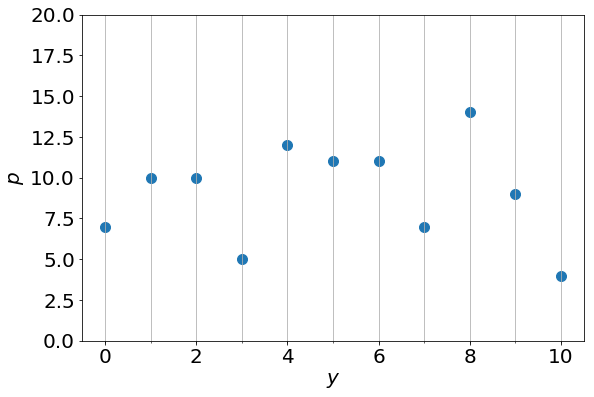

In [7]:
# ヒストグラムを描画する。
xs = np.arange(11)
plt.figure(figsize=(9,6))
plt.rcParams["font.size"] = 20
plt.scatter(xs, histo_ys, s=100)
plt.xlabel('$y$')
plt.ylabel('$p$')
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
plt.ylim(0, 20)
plt.show()

In [8]:
# MAP推定を行う。
model = pm.Model()
with model:
    q = pm.Uniform('q', lower=0, upper=1)
    y = pm.Binomial('y', n=10, p=q, observed=ys)
    map_estimate = pm.find_MAP(model=model)
print(map_estimate['q'])

logp = -316.78, ||grad|| = 4: 100%|██████████| 5/5 [00:00<00:00, 56.97it/s]


0.4960000053023121


In [9]:
# 推定したqを用いて二項分布を作る。
rv = scipy.stats.binom(10, map_estimate['q'])
binom_ys = [100 * rv.pmf(k) for k in range(11)]

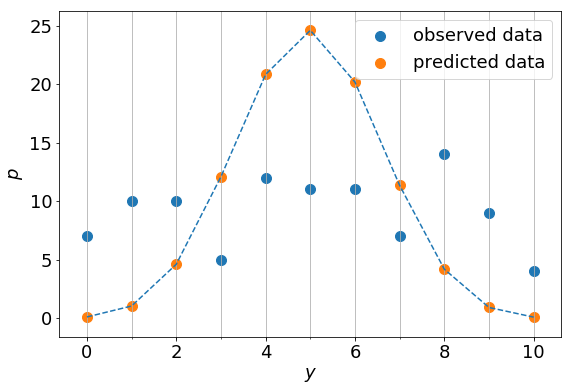

In [10]:
# この二項分布を描画する。
plt.figure(figsize=(9,6))
plt.rcParams["font.size"] = 18
plt.scatter(xs, histo_ys, s=100, label='observed data')
plt.plot(xs, binom_ys, ls='--')
plt.scatter(xs, binom_ys, s=100, label='predicted data')
plt.xlabel('$y$')
plt.ylabel('$p$')
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
plt.legend(loc='best')
plt.show()

In [11]:
# 階層ベイス推定をMCMCで解く。
model = pm.Model()
with model:
    beta = pm.Normal('beta', mu=0, tau=1.0e-2)
    tau = pm.Gamma('tau', alpha=1.0e-02, beta=1.0e-02)
    alpha = pm.Normal('alpha', mu=0, tau=tau , shape=len(ys))
    ymu = pm.math.sigmoid(beta + alpha)
    y = pm.Binomial('y', n=10, p=ymu, observed=ys)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(5000, start=start, step=step)
alpha.shape

logp = -48.984, ||grad|| = 0.031497: 100%|██████████| 33/33 [00:00<00:00, 1601.81it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, beta]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:30<00:00, 710.26draws/s] 


Shape.0

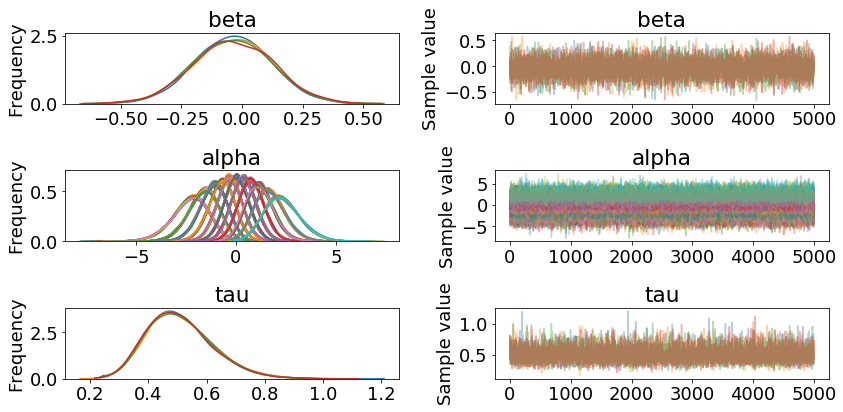

<Figure size 720x1440 with 0 Axes>

In [12]:
# 結果の確認
pm.traceplot(trace)
plt.figure(figsize=(10, 20))
plt.show()

左図はカーネル密度推定（KDE）のグラフ、右図はサンプル値。右図はホワイトノイズのように見えなければならない。特定のパターンが見えてはいけない。

In [13]:
# 収束をチェックする。
pm.gelman_rubin(trace)

{'alpha': array([1.00004731, 0.99995097, 1.00004984, 0.99995099, 1.00000901,
        0.99991364, 0.99991686, 1.00006626, 1.00004522, 0.99994756,
        1.0001184 , 0.99995091, 1.00001573, 1.0000299 , 0.99997357,
        0.99990426, 1.00007137, 1.0000727 , 0.99991395, 0.99992279,
        0.99997175, 0.99996754, 1.00002792, 0.99997047, 0.99997716,
        1.00010228, 1.00003519, 0.99999098, 0.99993212, 0.99995523,
        0.99998683, 0.99994296, 0.99996143, 0.99998349, 0.99999487,
        1.00036138, 1.00004412, 1.00012061, 0.99998936, 0.99997257,
        1.00000507, 0.99993187, 0.99991033, 1.0001537 , 0.99996674,
        1.00017935, 0.99992104, 0.99994459, 1.00001563, 0.99993892,
        0.99991545, 0.99994244, 0.99993043, 0.99995965, 0.99997867,
        1.00009575, 0.99996342, 0.99992233, 1.00003473, 0.99998462,
        0.9999276 , 0.99991897, 0.99997729, 0.99991923, 0.99993843,
        0.99991471, 0.99994014, 1.00004748, 0.99998831, 1.00002415,
        0.99995894, 0.99996751, 0.99994

経験則によれば、1.1未満が望ましい。

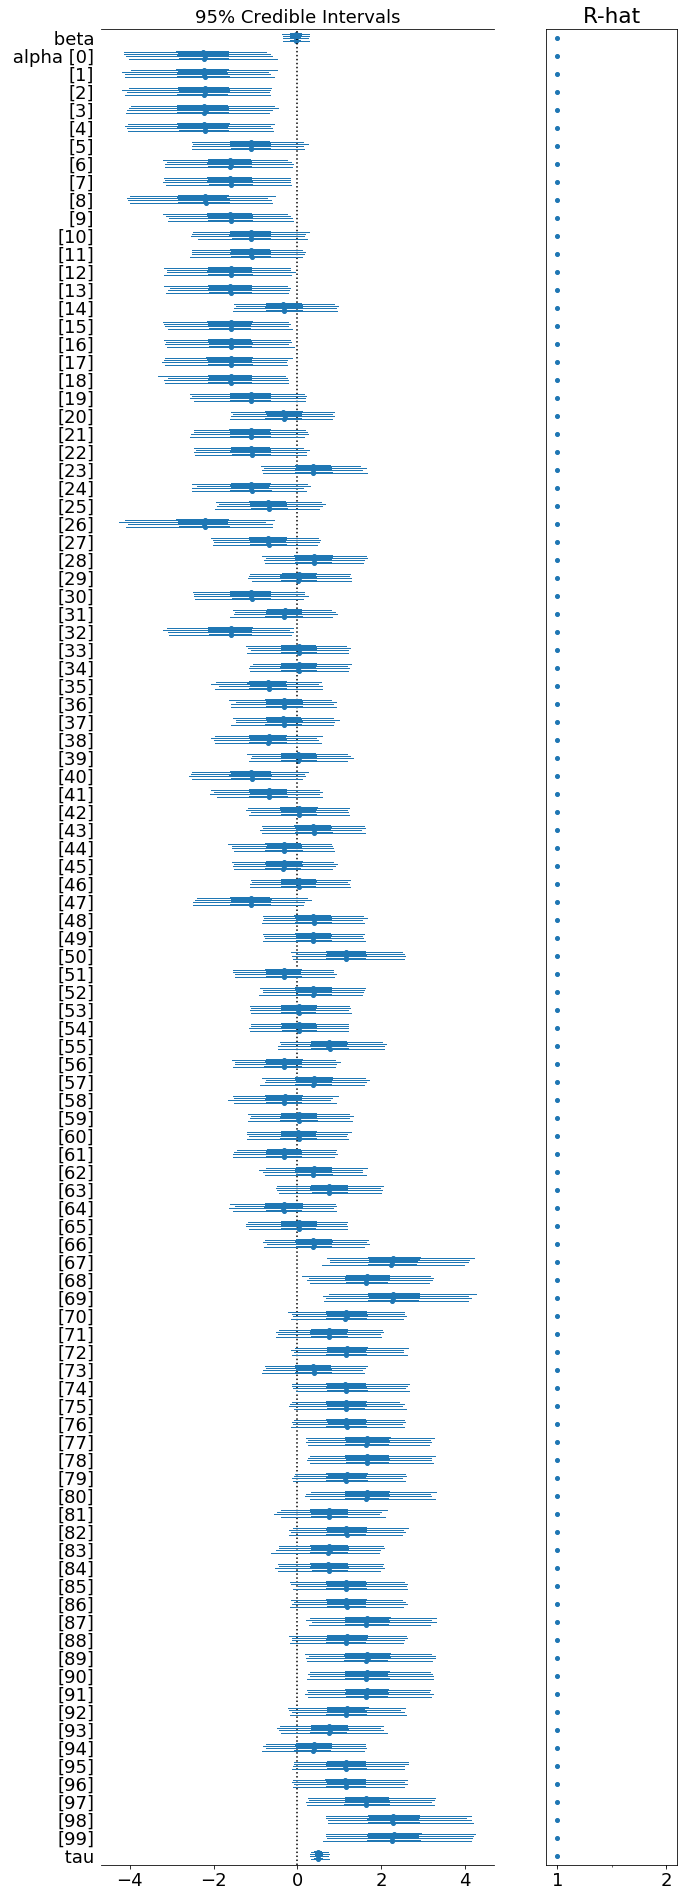

In [14]:
# 最高事後密度（HPD）を描画する。
plt.figure(figsize=(10, 30))
pm.forestplot(trace)

右図に、95%HPD（細線）, 50%HDP（太線）, 平均値が描画される。左図は$\hat{R}$である。

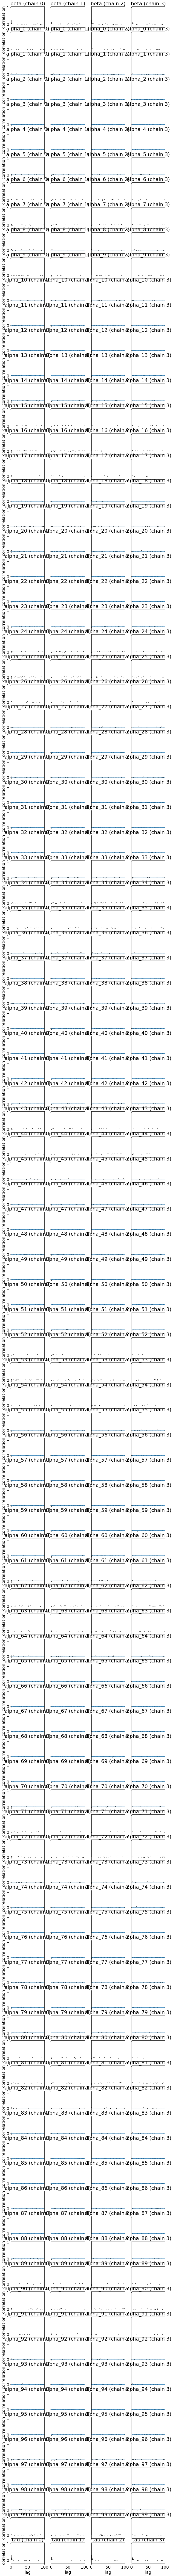

In [15]:
# 自己相関を見る。
pm.autocorrplot(trace)
plt.show()

理想的なサンプルには自己相関があってはいけない。ある点の数値は、別の点の数値と独立していなければならない。

In [16]:
# 統計量の要約を出力する。
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,-0.04,0.16,0.00,-0.35,0.28,10697.47,1.0
alpha__0,-2.28,0.89,0.01,-4.11,-0.64,17914.09,1.0
alpha__1,-2.29,0.91,0.01,-4.14,-0.64,17641.56,1.0
alpha__2,-2.28,0.89,0.01,-4.11,-0.65,16600.88,1.0
alpha__3,-2.28,0.90,0.01,-4.03,-0.56,19188.71,1.0
alpha__4,-2.28,0.90,0.01,-4.07,-0.60,17418.31,1.0
alpha__5,-1.13,0.69,0.00,-2.51,0.17,18564.47,1.0
alpha__6,-1.64,0.77,0.00,-3.21,-0.21,19777.67,1.0
alpha__7,-1.63,0.77,0.01,-3.17,-0.18,20403.59,1.0
alpha__8,-2.28,0.89,0.01,-4.04,-0.63,16928.86,1.0


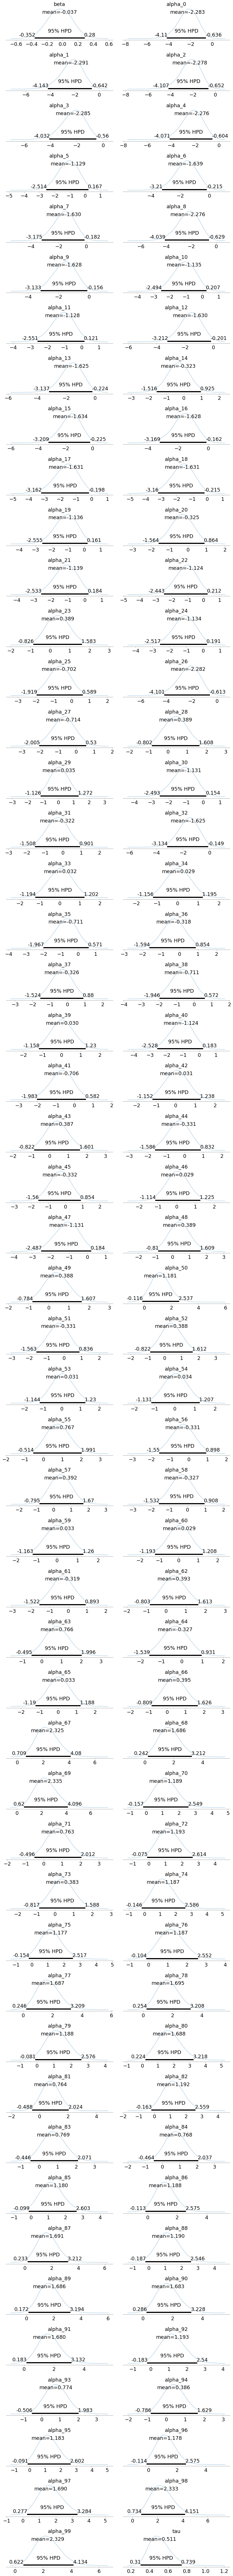

In [17]:
# 未知パラメータの事後分布
pm.plot_posterior(trace, kde_plot=True)
plt.show()

In [18]:
# 事後分布を求める。
sample_size, _ = trace['alpha'].shape
posterior = pm.sample_ppc(trace, sample_size, model=model)

100%|██████████| 20000/20000 [00:09<00:00, 2052.10it/s]


In [27]:
# yの事後分布
y_posterior = posterior['y']
print(y_posterior.shape)

(20000, 100)


In [28]:
# sample_sizeの数だけヒストグラムを作る。
pred_ys = np.empty((sample_size, bins))
for i, k in enumerate(y_posterior):
    pred_ys[i] = np.histogram(k, bins)[0]

In [29]:
# 平均をとる。
pred_mean = pred_ys.mean(axis=0)

# 標準偏差を計算する。
pred_std = pred_ys.std(axis=0)

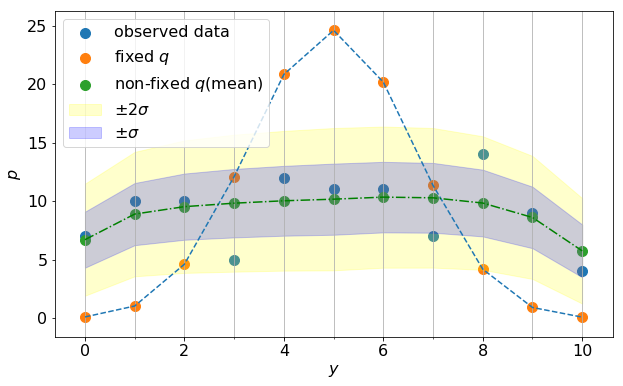

In [49]:
#  描画する。
plt.figure(figsize=(10,6))
plt.rcParams['font.size'] = 16
plt.scatter(xs, histo_ys, s=100, label='observed data')

plt.plot(xs, binom_ys, ls='--')
plt.scatter(xs, binom_ys, s=100, label='fixed $q$')

plt.xlabel('$y$')
plt.ylabel('$p$')

plt.plot(xs, pred_mean, ls='-.', c='g')
plt.scatter(xs, pred_mean, s=100, label='non-fixed $q$(mean)')

plt.fill_between(xs, pred_mean - 2*pred_std, pred_mean + 2*pred_std, color='yellow', alpha=0.2, label='$\pm2\sigma$')
plt.fill_between(xs, pred_mean - pred_std, pred_mean + pred_std, color='blue', alpha=0.2, label='$\pm\sigma$')

plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
plt.legend(loc='upper left')
plt.show()

In [32]:
sig = pm.hpd(y_posterior, alpha=0.05)
print(sig.shape)

(100, 2)


In [35]:
lower = np.histogram(sig[:, 0], bins)[0]
upper = np.histogram(sig[:, 1], bins)[0]

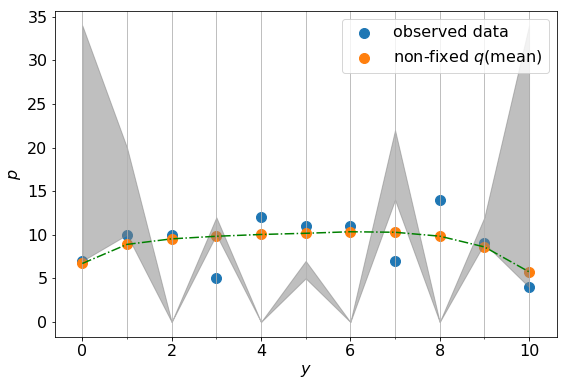

In [38]:
#  描画する。
plt.figure(figsize=(9,6))
plt.rcParams['font.size'] = 16
plt.scatter(xs, histo_ys, s=100, label='observed data')

# plt.plot(xs, binom_ys, ls='--')
# plt.scatter(xs, binom_ys, s=100, label='fixed $q$')

plt.xlabel('$y$')
plt.ylabel('$p$')

plt.plot(xs, pred_mean, ls='-.', c='g')
plt.scatter(xs, pred_mean, s=100, label='non-fixed $q$(mean)')

plt.fill_between(xs, lower, upper, color='gray', alpha=0.5)

plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
plt.legend(loc='best')
plt.show()